# Anomaly Detection in Data


## Setup

Import required modules:

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

np.errstate(divide='ignore', invalid='ignore')

Load data:

In [ ]:
labels=['x', 'y', 'class']
names=['compound', 'flame','pathbased']
D=[]

for name in names:
    d = pd.read_csv('data/'+name+'.txt', sep='\t', names=labels)
    d.drop('class', axis=1, inplace=True)
    D.append(d)

In [ ]:
GD = pd.read_csv('data/G-data.csv', sep=',', names=labels[:-1])

In [ ]:
GD.iloc[:,]

,x,y
0,8.724514,16.680705
1,8.111094,14.039865
2,3.891538,11.217337
3,6.595019,16.108606
4,9.159665,15.282327
...,...,...
245,3.156732,13.434926
246,6.588365,15.036372
247,7.806401,13.882248
248,8.672002,14.524847


## 1. Parametric Models

In [ ]:
def plot_parametric(D):
  N,d = D.shape
  delta = pd.DataFrame(100*np.divide(D.iloc[:1,:].values - D.iloc[:N-1,:].values, D.iloc[:N-1,:].values),
  columns=labels[:-1], index=D.iloc[1:].index)

  mean = delta.mean()
  cov = delta.cov()

  X = delta.values
  S = cov.values

  for i in range(2):
    X[:,i] = X[:,i] - mean[i]

  def mahalanobis(x):
    return np.matmul(x,S).dot(x)

  anom = np.apply_along_axis(mahalanobis, axis=1, arr=X)

  plt.scatter(delta.x, delta.y, c=anom, cmap='jet')
  plt.colorbar()

  anom = pd.DataFrame(anom, columns=['anomaly'], index=D.iloc[1:].index)
  result = pd.concat([D.iloc[1:], anom], axis=1)
  return result.nlargest(5, 'anomaly')


,x,y,anomaly
9,5.260229,14.310686,1.075778e+11
95,5.812317,13.903290,5.719825e+09
39,5.728176,11.482568,3.360533e+09
89,10.837836,18.865017,2.494888e+09
112,3.248710,12.977121,1.822316e+09


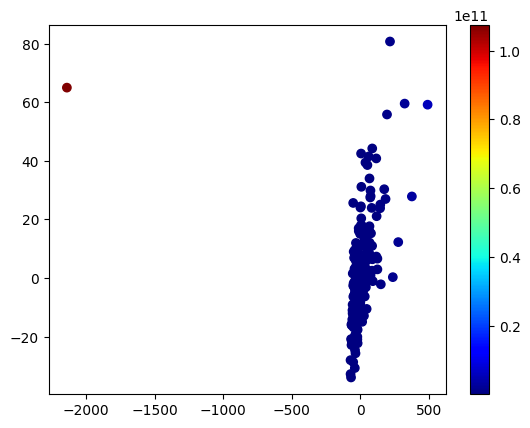

In [ ]:
plot_parametric(GD)

## 2. Distance based Models

In [ ]:
def plot_distance(D, k):
  N,d = D.shape
  delta = pd.DataFrame(100*np.divide(D.iloc[:1,:].values - D.iloc[:N-1,:].values, D.iloc[:N-1,:].values),
  columns=labels[:-1], index=D.iloc[1:].index)

  clf = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(delta.values)
  distances, indices = clf.kneighbors(delta.values)

  anom = distances[:,k]
  plt.scatter(delta.x, delta.y, c=anom, cmap='jet')
  plt.colorbar()
  plt.title('K = '+str(k))
  anom = pd.DataFrame(anom, columns=['anomaly'], index=D.iloc[1:].index)
  result = pd.concat([D.iloc[1:], anom], axis=1)
  return result.nlargest(5, 'anomaly')

### compound

,x,y,anomaly
152,7.15,19.90,21.001931
157,8.95,18.00,20.077842
297,13.20,5.85,18.888742
158,9.60,18.85,17.593315
262,10.35,10.20,16.462091


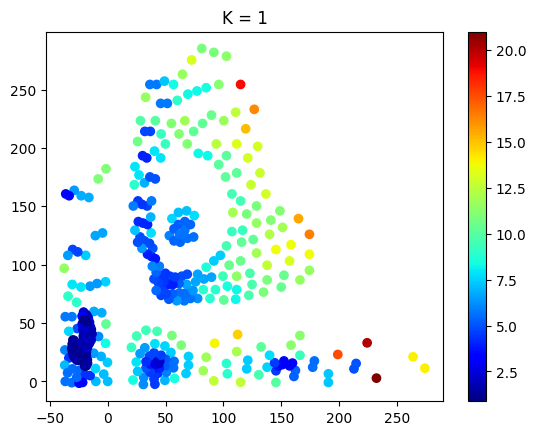

In [ ]:
plot_distance(D[0], 1)

,x,y,anomaly
153,8.55,20.00,42.687110
156,8.25,16.65,36.534506
20,29.15,8.10,25.095147
157,8.95,18.00,25.019353
297,13.20,5.85,24.175833


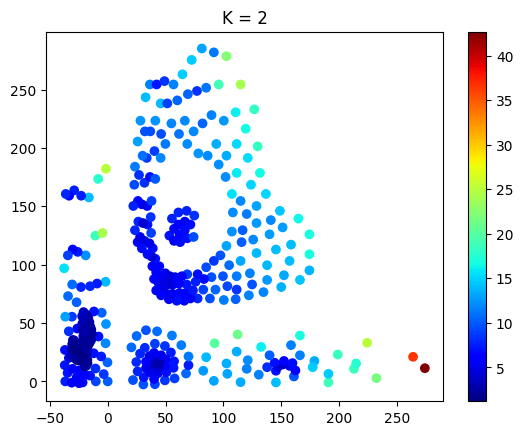

In [ ]:
plot_distance(D[0], 2)

,x,y,anomaly
153,8.55,20.00,61.262905
156,8.25,16.65,52.105881
157,8.95,18.00,41.475477
152,7.15,19.90,39.083495
307,13.95,5.80,33.840205


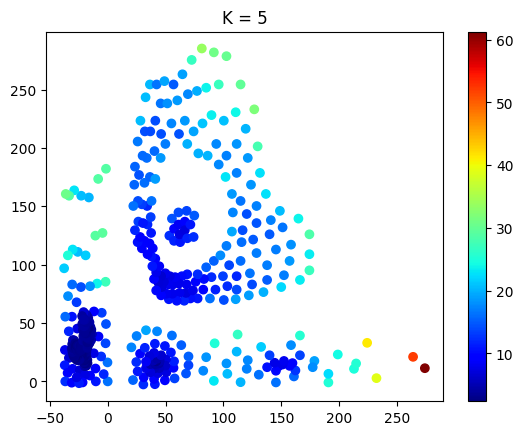

In [ ]:
plot_distance(D[0], 5)

### flame

,x,y,anomaly
5,0.65,21.35,85.583145
6,1.10,22.05,67.653395
4,0.50,22.35,49.766735
7,1.35,22.65,22.764750
1,1.35,26.65,22.521450


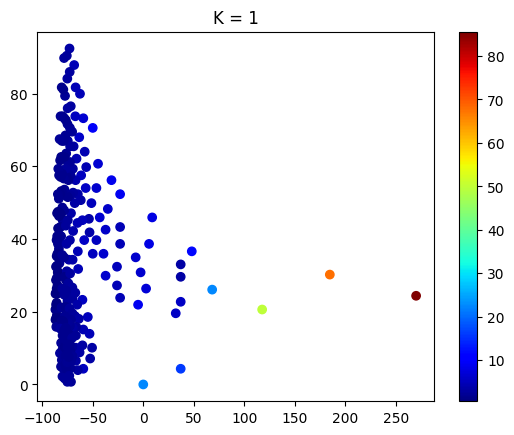

In [ ]:
plot_distance(D[1], 1)

,x,y,anomaly
5,0.65,21.35,152.399762
6,1.10,22.05,85.583145
4,0.50,22.35,67.653395
7,1.35,22.65,31.323339
1,1.35,26.65,26.509571


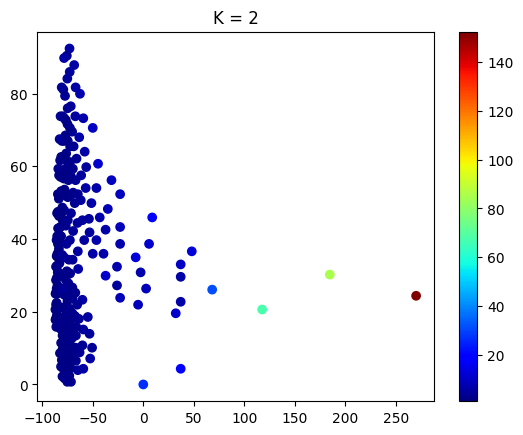

In [ ]:
plot_distance(D[1], 2)

,x,y,anomaly
5,0.65,21.35,232.968788
6,1.10,22.05,147.579596
4,0.50,22.35,81.110480
7,1.35,22.65,36.621721
1,1.35,26.65,35.747088


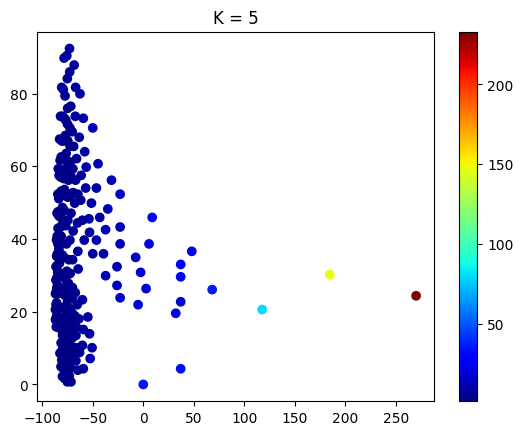

In [ ]:
plot_distance(D[1], 5)

### pathbased

,x,y,anomaly
14,5.70,12.95,17.097514
102,25.50,4.10,15.194095
203,10.10,10.05,14.810770
204,11.75,12.20,11.482057
100,26.40,4.40,9.565746


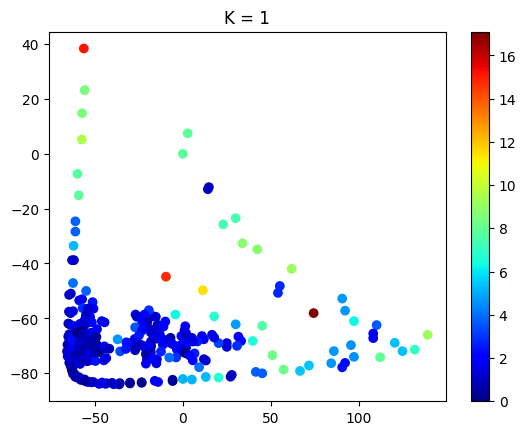

In [ ]:
plot_distance(D[2], 1)

,x,y,anomaly
102,25.50,4.10,23.604250
2,9.85,5.80,23.028775
1,10.95,4.70,19.160463
14,5.70,12.95,17.911109
8,6.95,8.70,16.773938


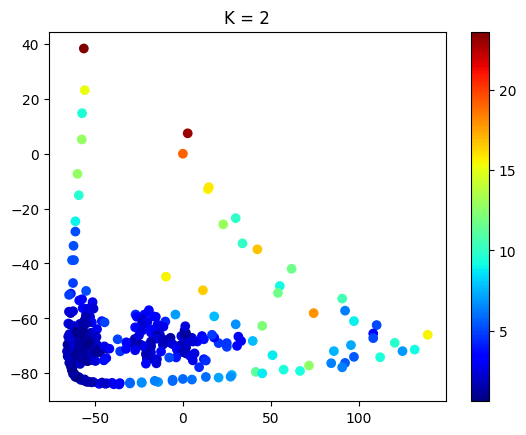

In [ ]:
plot_distance(D[2], 2)

,x,y,anomaly
102,25.50,4.1,53.557767
2,9.85,5.8,41.267963
103,31.60,16.6,38.443614
1,10.95,4.7,38.144589
100,26.40,4.4,30.058821


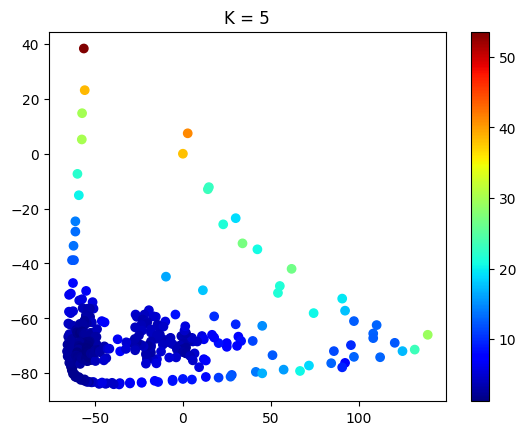

In [ ]:
plot_distance(D[2], 5)

## 3. Density based Models - Part A

In [ ]:
def plot_density(D, k):
  D = D.drop_duplicates()
  N,d = D.shape
  delta = pd.DataFrame(100*np.divide(D.iloc[:1,:].values - D.iloc[:N-1,:].values, D.iloc[:N-1,:].values),
  columns=labels[:-1], index=D.iloc[1:].index)

  clf = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(delta.values)
  distances, indices = clf.kneighbors(delta.values)

  top = np.divide(np.sum(np.divide(1., distances[:,1:]), axis=1), k)
  bottom = np.divide(1., distances[:,k])
  anom = np.divide(top, bottom)

  plt.scatter(delta.x, delta.y, c=anom, cmap='jet')
  plt.colorbar()
  plt.title('K = '+str(k))
  anom = pd.DataFrame(anom, columns=['anomaly'], index=D.iloc[1:].index)
  result = pd.concat([D.iloc[1:], anom], axis=1)
  return result.nsmallest(5, 'anomaly')

### compound

,x,y,anomaly
1,29.80,22.15,1.0
2,31.55,21.10,1.0
3,27.70,20.85,1.0
4,29.90,19.95,1.0
5,26.80,19.05,1.0


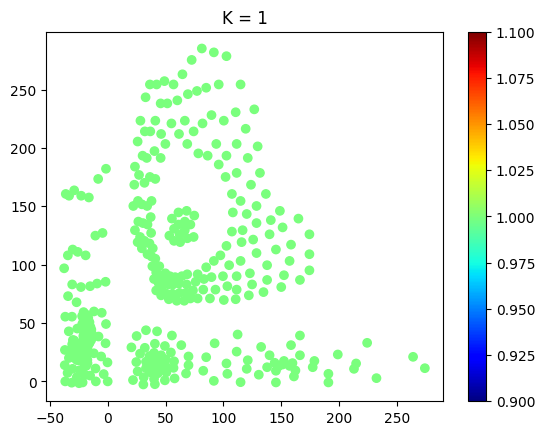

In [ ]:
plot_density(D[0], 1)

,x,y,anomaly
240,12.00,11.50,1.000515
266,12.90,9.70,1.000684
312,16.70,6.50,1.001570
326,17.55,12.10,1.002086
242,13.40,11.65,1.002824


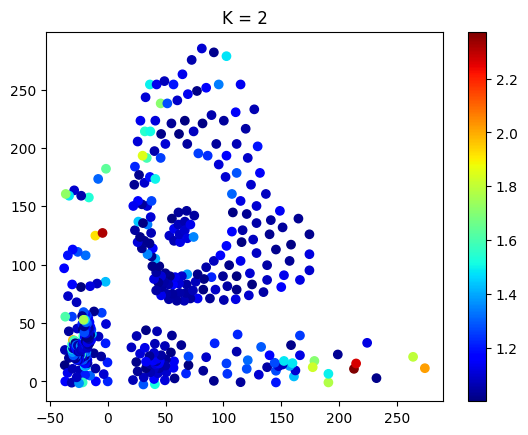

In [ ]:
plot_density(D[0], 2)

,x,y,anomaly
242,13.40,11.65,1.016241
236,13.85,12.40,1.037782
191,17.05,19.85,1.067633
394,15.85,9.95,1.075811
46,33.25,21.00,1.077295


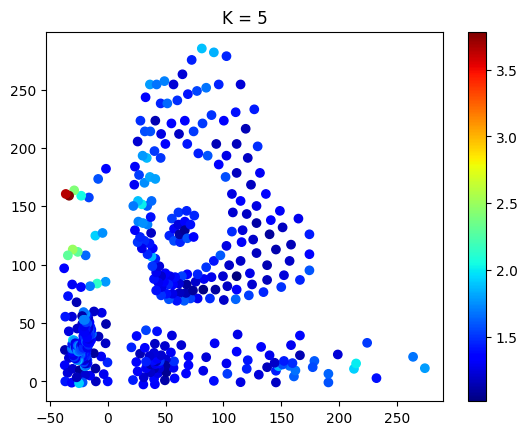

In [ ]:
plot_density(D[0], 5)

### flame

,x,y,anomaly
1,1.35,26.65,1.0
2,1.40,23.25,1.0
3,0.85,23.05,1.0
4,0.50,22.35,1.0
5,0.65,21.35,1.0


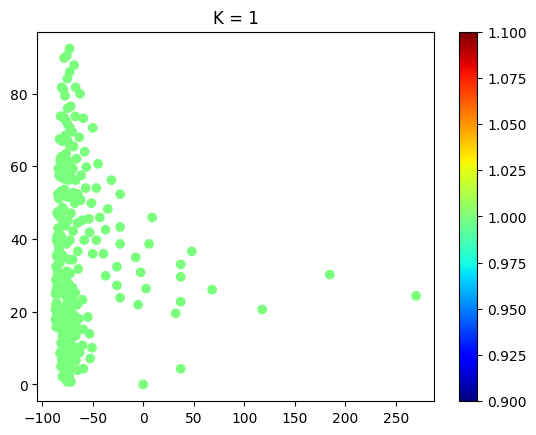

In [ ]:
plot_density(D[1], 1)

,x,y,anomaly
58,5.95,16.80,1.000074
171,7.40,22.60,1.000912
233,6.60,26.60,1.002215
213,8.15,26.35,1.002702
186,6.50,23.60,1.003137


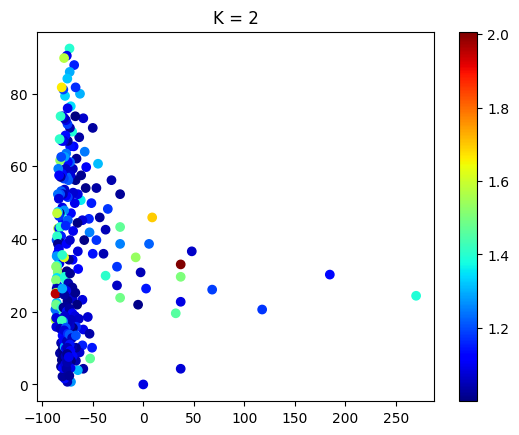

In [ ]:
plot_density(D[1], 2)

,x,y,anomaly
53,4.55,16.05,1.063026
172,7.75,22.10,1.064815
227,6.20,25.20,1.097080
180,6.20,23.25,1.103222
236,7.50,25.65,1.104437


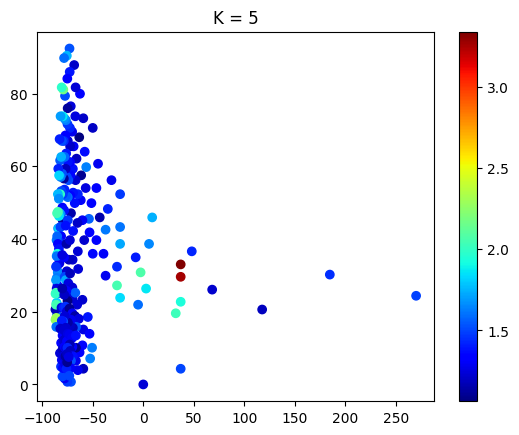

In [ ]:
plot_density(D[1], 5)

### pathbased

,x,y,anomaly
1,10.95,4.70,1.0
2,9.85,5.80,1.0
3,9.80,5.75,1.0
4,9.15,6.80,1.0
5,8.65,6.60,1.0


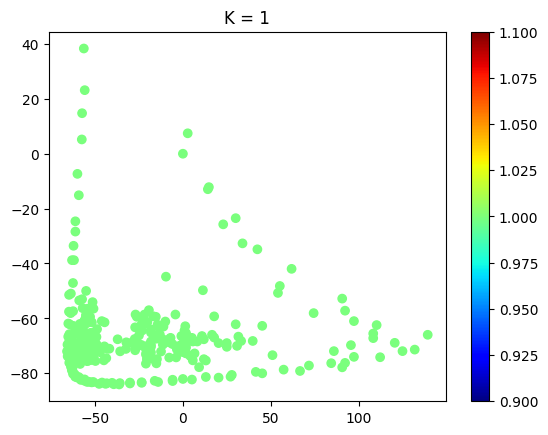

In [ ]:
plot_density(D[2], 1)

,x,y,anomaly
258,11.05,17.20,1.001443
192,22.50,17.80,1.001600
108,29.95,13.55,1.001746
291,15.50,15.55,1.002043
227,11.10,13.60,1.003479


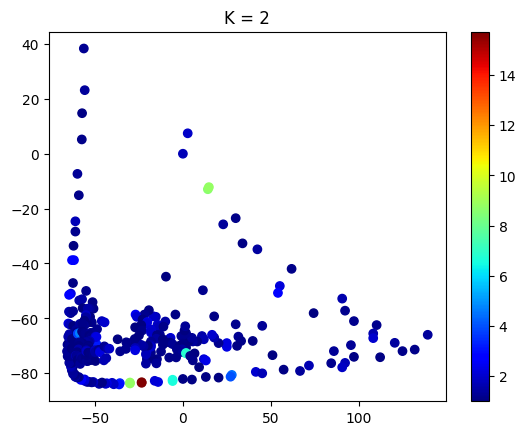

In [ ]:
plot_density(D[2], 2)

,x,y,anomaly
107,30.50,15.55,1.032245
203,10.10,10.05,1.041514
108,29.95,13.55,1.051608
163,27.55,17.95,1.075621
243,14.65,14.20,1.092889


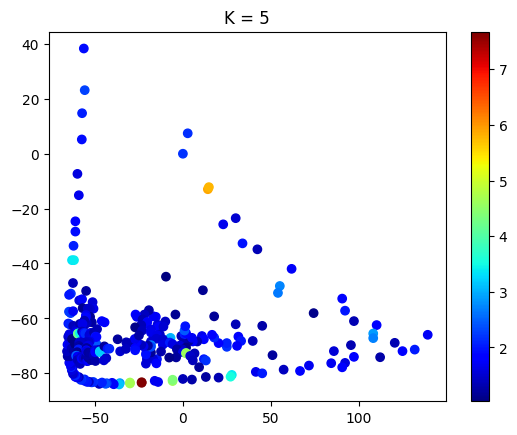

In [ ]:
plot_density(D[2], 5)

## 3. Density based Models - Part B

In [ ]:
def plot_density(D, k):
  D = D.drop_duplicates()
  N,d = D.shape
  delta = pd.DataFrame(100*np.divide(D.iloc[:1,:].values - D.iloc[:N-1,:].values, D.iloc[:N-1,:].values),
  columns=labels[:-1], index=D.iloc[1:].index)

  clf = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(delta.values)
  distances, indices = clf.kneighbors(delta.values)

  top = np.divide(np.sum(np.divide(1., distances[:,1:]), axis=1), k)
  bottom = np.divide(1., distances[:,1:].mean())
  anom = np.divide(top, bottom)

  plt.scatter(delta.x, delta.y, c=anom, cmap='jet')
  plt.colorbar()
  plt.title('K = '+str(k))
  anom = pd.DataFrame(anom, columns=['anomaly'], index=D.iloc[1:].index)
  result = pd.concat([D.iloc[1:], anom], axis=1)
  return result.nsmallest(5, 'anomaly')

### compound

,x,y,anomaly
152,7.15,19.90,0.303561
157,8.95,18.00,0.317532
297,13.20,5.85,0.337522
158,9.60,18.85,0.362374
262,10.35,10.20,0.387275


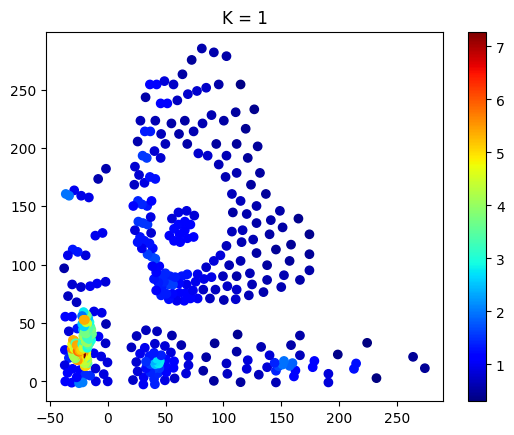

In [ ]:
plot_density(D[0], 1)

,x,y,anomaly
157,8.95,18.00,0.328330
152,7.15,19.90,0.343239
297,13.20,5.85,0.344897
153,8.55,20.00,0.345359
156,8.25,16.65,0.359787


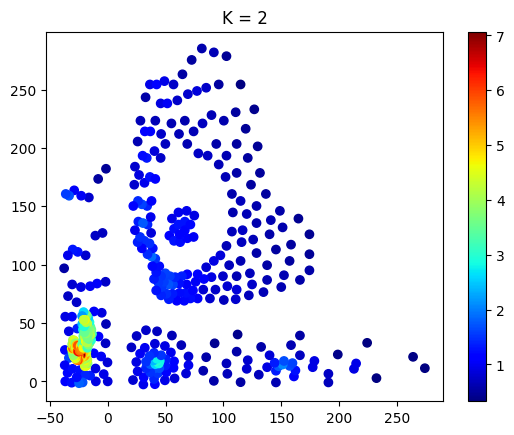

In [ ]:
plot_density(D[0], 2)

,x,y,anomaly
153,8.55,20.00,0.280537
156,8.25,16.65,0.311163
152,7.15,19.90,0.343655
157,8.95,18.00,0.350905
297,13.20,5.85,0.395360


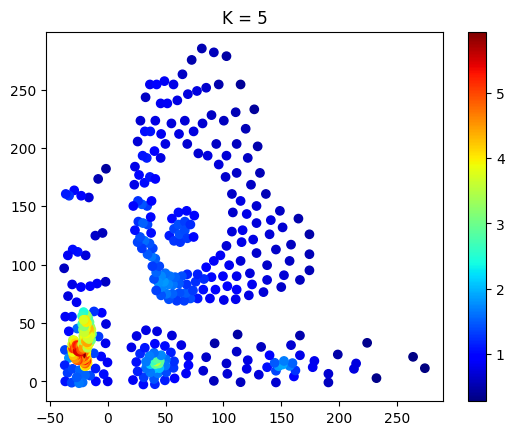

In [ ]:
plot_density(D[0], 5)

### flame

,x,y,anomaly
5,0.65,21.35,0.046000
6,1.10,22.05,0.058191
4,0.50,22.35,0.079105
7,1.35,22.65,0.172934
1,1.35,26.65,0.174802


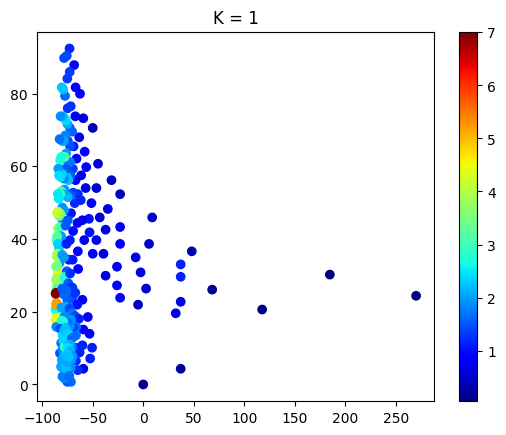

In [ ]:
plot_density(D[1], 1)

,x,y,anomaly
5,0.65,21.35,0.042217
6,1.10,22.05,0.061235
4,0.50,22.35,0.080692
7,1.35,22.65,0.175505
1,1.35,26.65,0.190016


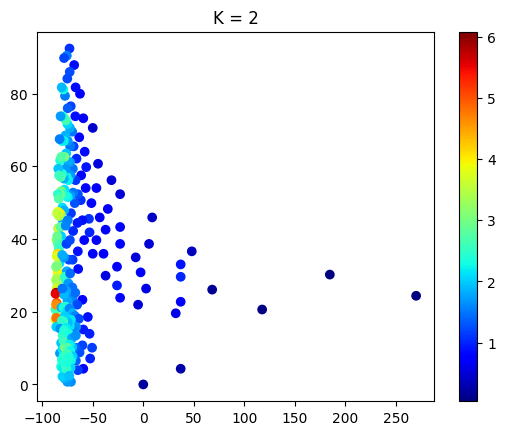

In [ ]:
plot_density(D[1], 2)

,x,y,anomaly
5,0.65,21.35,0.040355
6,1.10,22.05,0.061983
4,0.50,22.35,0.092839
7,1.35,22.65,0.209906
1,1.35,26.65,0.217811


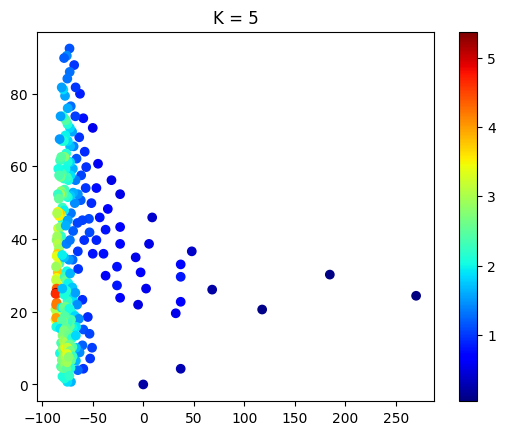

In [ ]:
plot_density(D[1], 5)

### pathbased

,x,y,anomaly
14,5.70,12.95,0.129920
102,25.50,4.10,0.146195
203,10.10,10.05,0.149979
204,11.75,12.20,0.193459
100,26.40,4.40,0.232214


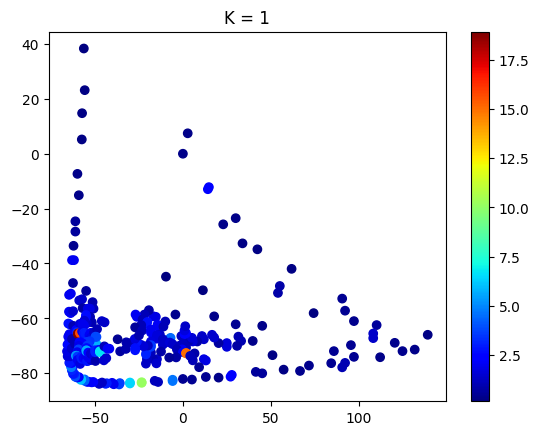

In [ ]:
plot_density(D[2], 1)

,x,y,anomaly
102,25.50,4.10,0.163683
14,5.70,12.95,0.172971
203,10.10,10.05,0.199111
204,11.75,12.20,0.223394
2,9.85,5.80,0.256388


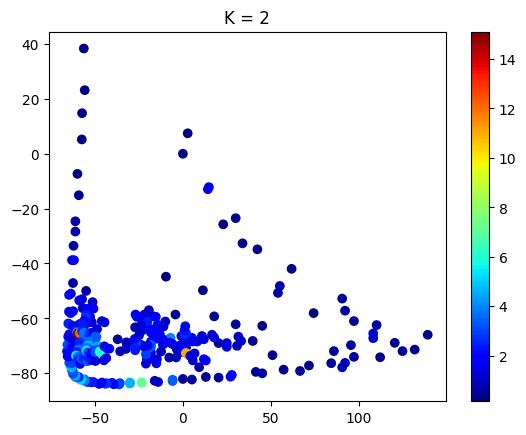

In [ ]:
plot_density(D[2], 2)

,x,y,anomaly
102,25.50,4.10,0.166662
2,9.85,5.80,0.244361
14,5.70,12.95,0.252158
1,10.95,4.70,0.266072
18,5.40,15.40,0.275498


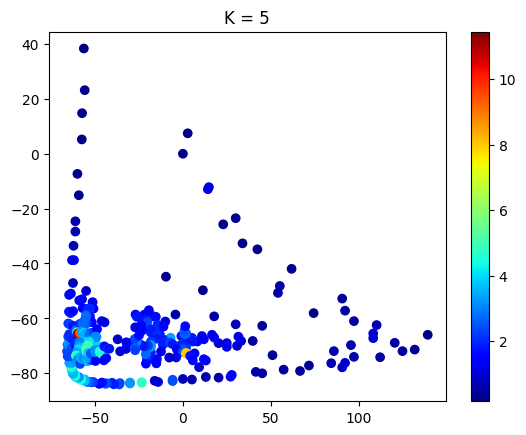

In [ ]:
plot_density(D[2], 5)